<a href="https://colab.research.google.com/github/conwerner/ocr_rnn/blob/main/notebooks/ocr_rnn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/conwerner/ocr_rnn.git

Cloning into 'ocr_rnn'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 273 (delta 133), reused 67 (delta 46), pack-reused 0
Receiving objects: 100% (273/273), 318.82 KiB | 4.14 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [2]:
!pip install textdistance
!pip install shiftlab_ocr

     |████████████████████████████████| 30.7 MB 1.7 MB/s 


In [3]:
import sys
sys.path.append("/content/ocr_rnn/src")
sys.path.append("/content/ocr_rnn/src/models")
import matplotlib.pyplot as plt
import torch
from config import *
from dataset import OCRdataset, Collator
from loss import CustomCTCLoss
from utils import *
import model3

PREPARE SOME DEMOSTRATION DATA

In [4]:
!mkdir /content/train_images
!mkdir /content/test_images

from shiftlab_ocr import Generator
from PIL import Image

g = Generator(lang='ru')
g.upload_source('/content/ocr_rnn/notebooks/words.txt')

# train
b = g.generate_batch(10000,4,7)
f = open('/content/train_labels.txt', 'w')
for idx, b_i in enumerate(b):
  img = b_i[0].resize((256,64), Image.ANTIALIAS)
  img.save("/content/train_images/" + b_i[1] + '_' + str(idx) + '.png')
  _ = f.write(b_i[1] + '_' + str(idx) + '.png\t' + b_i[1] + '\n')
f.close()

# test
b = g.generate_batch(2000,4,7)
f = open('/content/test_labels.txt', 'w')
for idx, b_i in enumerate(b):
  img = b_i[0].resize((256,64), Image.ANTIALIAS)
  img.save("/content/test_images/" + b_i[1] + '_' + str(idx) + '.png')
  _ = f.write(b_i[1] + '_' + str(idx) + '.png\t' + b_i[1] + '\n')
f.close()

14 expressions have been udploaded


TRAIN A MODEL

In [5]:
PATH_TO_IMGDIR = "/content/train_images/"
PATH_TO_LABELS = "/content/train_labels.txt"

dataset = OCRdataset(PATH_TO_IMGDIR, PATH_TO_LABELS)
collator = Collator()
loader = torch.utils.data.DataLoader(dataset, batch_size = 128, collate_fn = collator)
model = model3.Model(256, len(ALPHABET))
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = CustomCTCLoss()

In [6]:
fit(model, optimizer, loss_fn, loader, epochs = 12)

epoch | mean loss | mean cer | mean wer | time
0       5.114       1.000       1.000      161.6
1       2.632       0.916       1.000      162.8
2       2.068       0.709       0.995      164.1
3       1.349       0.520       0.941      163.9
4       0.812       0.331       0.732      163.8
5       0.407       0.161       0.425      163.8
6       0.146       0.073       0.242      163.5
7       0.067       0.043       0.147      162.9
8       0.045       0.030       0.113      162.9
9       0.044       0.024       0.097      162.7
10       0.054       0.021       0.092      162.7
11       0.062       0.019       0.088      162.8


TEST

In [7]:
result = predict(model, "/content/test_images/")

100%|██████████| 2000/2000 [00:41<00:00, 48.52it/s]


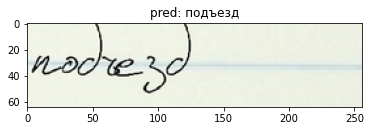

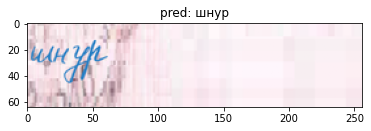

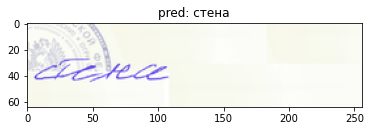

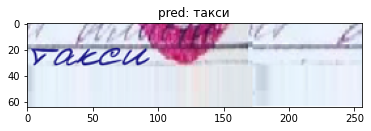

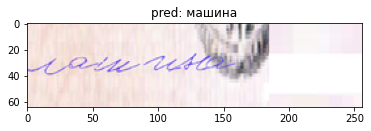

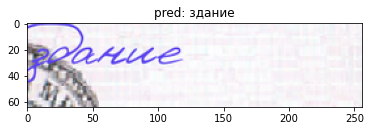

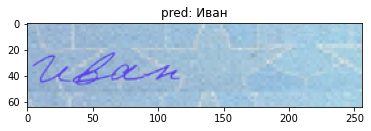

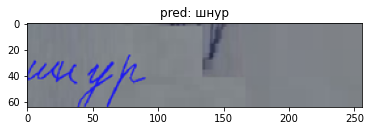

In [8]:
for image_name, pred_label in zip(result['image_name'][0:8],result['pred_label'][0:8]):
  image = plt.imread("/content/test_images/"+image_name)
  plt.title('pred: '+pred_label)
  plt.imshow(image)
  plt.show()